# **Tabular Classification**

In [1]:
!pip install opendatasets --quiet
import opendatasets as od      #KGAT_ec96c86d4493570fe6d3cd0ea3bef9de
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thviewer
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.24GB/s]

In [2]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac


In [3]:
data = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data.dropna(inplace = True)
data.drop(['id'],axis = 1,inplace=True)
data.shape

(18185, 11)

In [5]:
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
data['Class'].value_counts()

,count
Class,
1,9985
0,8200


In [7]:
#Norm
orignal = data.copy()

for column in data.columns:
  data[column] = data[column]/data[column].abs().max()
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [8]:
#split
x = np.array(data.iloc[:,:-1])
y = np.array(data.iloc[:,-1])



In [9]:
x_train , x_test , y_train ,y_test = train_test_split(x,y,test_size=0.3)

In [10]:
x_test ,x_val , y_test , y_val = train_test_split(x_test,y_test,test_size=0.5)


In [11]:
print(x_test.shape)
print(x_val.shape)
print(x_train.shape)

(2728, 10)
(2728, 10)
(12729, 10)


In [26]:
class dataset(Dataset):
  def __init__(self,X,Y):
    super().__init__()
    self.X = torch.tensor(X,dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y,dtype=torch.float32).to(device)
  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index],self.Y[index]

In [27]:
training_data = dataset(x_train,y_train)
validation_data = dataset(x_val,y_val)
testing_data = dataset(x_test,y_test)

In [28]:
train_dataloader = DataLoader(training_data,batch_size=32,shuffle=True)
val_dataloader = DataLoader(validation_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(testing_data,batch_size=32,shuffle=True)

In [15]:
class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.input = nn.Linear(x.shape[1],10)
    self.linear = nn.Linear(10,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.input(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = Model().to(device)


In [16]:
summary(model,(1,x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             110
            Linear-2                 [-1, 1, 1]              11
           Sigmoid-3                 [-1, 1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [17]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=1e-3)

In [34]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(10):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.0178 Train Accuracy: 98.5152 Validation Loss: 0.0035 Validation Accuracy: 98.9370
Epoch no. 2 Train Loss: 0.0175 Train Accuracy: 98.4995 Validation Loss: 0.0041 Validation Accuracy: 98.6437
Epoch no. 3 Train Loss: 0.0173 Train Accuracy: 98.4916 Validation Loss: 0.0035 Validation Accuracy: 99.0103
Epoch no. 4 Train Loss: 0.0172 Train Accuracy: 98.4759 Validation Loss: 0.0035 Validation Accuracy: 98.7903
Epoch no. 5 Train Loss: 0.0169 Train Accuracy: 98.5545 Validation Loss: 0.0034 Validation Accuracy: 99.0469
Epoch no. 6 Train Loss: 0.0170 Train Accuracy: 98.4681 Validation Loss: 0.0034 Validation Accuracy: 98.9370
Epoch no. 7 Train Loss: 0.0169 Train Accuracy: 98.4995 Validation Loss: 0.0035 Validation Accuracy: 98.7537
Epoch no. 8 Train Loss: 0.0169 Train Accuracy: 98.4916 Validation Loss: 0.0035 Validation Accuracy: 98.8270
Epoch no. 9 Train Loss: 0.0167 Train Accuracy: 98.5545 Validation Loss: 0.0036 Validation Accuracy: 98.6437
Epoch no. 10 Train Loss: 0.0

In [33]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs,labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction,labels).item()
    total_loss_test += batch_loss_test
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

  print(f"Accuracy ={round(total_acc_test/testing_data.__len__()*100, 4)} ")

Accuracy =99.0103 


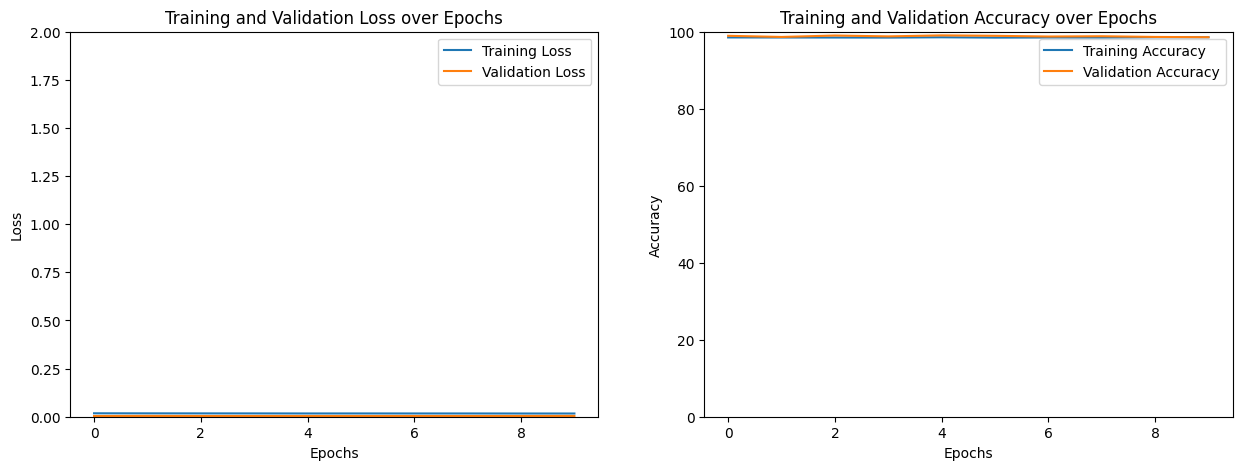

In [38]:
#Graph
fig ,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label='Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_validation_plot,label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].set_ylim([0,100])

plt.show()
